**Importing Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import cudf
import cupy as cp
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.ensemble import RandomForestClassifier
from cuml.metrics import accuracy_score as cu_accuracy_score, roc_auc_score as cu_roc_auc_score
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
ganda_data = pd.read_csv('Preprocessed.csv')
ganda_data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,target
0,27.750000,55.00000,B,875.98,No,8,44.16,0
1,31.330000,39.00000,C,839.91,No,4,13.93,1
2,23.870001,10.00000,A,1364.70,Yes,4,15.16,0
3,35.639999,34.00000,C,1462.07,No,4,15.71,1
4,29.990843,49.43656,C,710.61,No,8,13.77,1


**Encoding**

In [ ]:
X = ganda_data[['feature_4', 'feature_5', 'feature_6', 'feature_7']].copy()
y = ganda_data['target']

X['feature_5'] = X['feature_5'].str.lower().map({'yes': 1, 'no': 0})

**Train/Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
print("      Shape: ", X.shape)
print("\nTrain Shape: ", X_train.shape)
print(" Test Shape: ", X_test.shape)

      Shape:  (41000, 4)

Train Shape:  (32800, 4)
 Test Shape:  (8200, 4)


**Scaling**

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Class Imbalance**

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

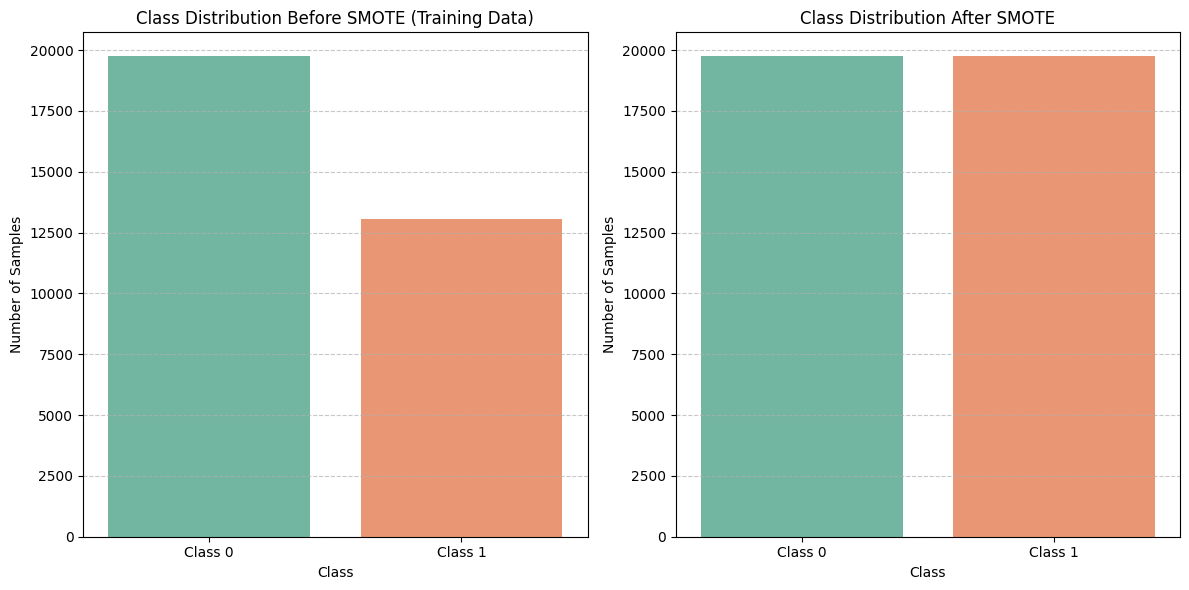

In [ ]:
class_counts_before = y_train.value_counts().sort_index()
class_counts_after = y_train_resampled.value_counts().sort_index()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=class_counts_before.index, y=class_counts_before.values, hue=class_counts_before.index, palette='Set2', legend=False)
plt.title('Class Distribution Before SMOTE (Training Data)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
sns.barplot(x=class_counts_after.index, y=class_counts_after.values, hue=class_counts_after.index, palette='Set2', legend=False)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Exploring the Data**

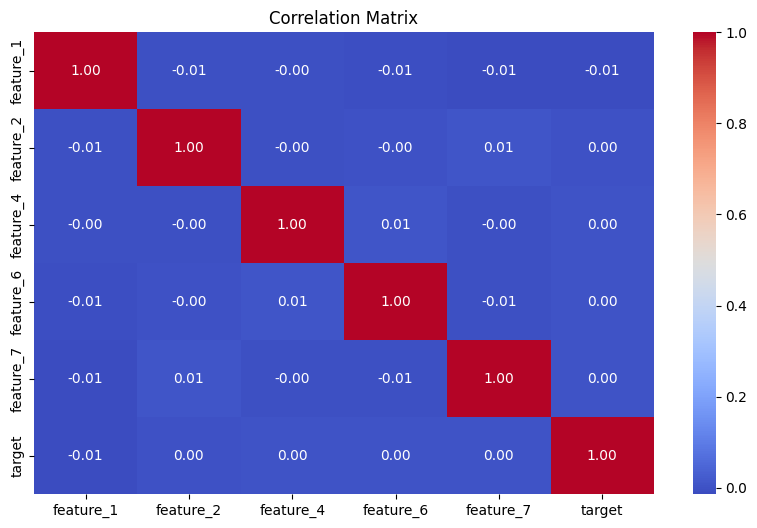

In [ ]:
corr_matrix = ganda_data.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

There are no linear relationship between variables.

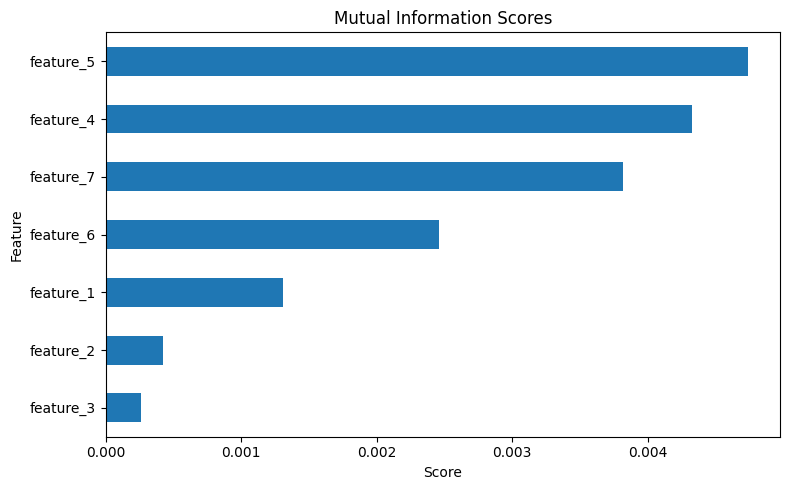

In [ ]:
label_enc = LabelEncoder()
ganda_data['feature_3'] = label_enc.fit_transform(ganda_data['feature_3'])
ganda_data['feature_5'] = ganda_data['feature_5'].str.lower().map({'yes': 1, 'no': 0})
X = ganda_data.drop(columns='target')
y = ganda_data['target']

mi_scores = mutual_info_classif(X, y, random_state=0)
mi_df = pd.Series(mi_scores, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
mi_df.plot(kind='barh')
plt.title('Mutual Information Scores')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Model Training - CPU

In [ ]:
start_time = time.time()

base_lgbm = lgb.LGBMClassifier(class_weight='balanced', random_state=42)
bagging_clf = BaggingClassifier(
    estimator=base_lgbm,
    n_estimators=50,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

bagging_clf.fit(X_train_resampled, y_train_resampled)

y_train_pred = bagging_clf.predict(X_train_scaled)
y_train_proba = bagging_clf.predict_proba(X_train_scaled)[:, 1]
y_test_pred = bagging_clf.predict(X_test_scaled)
y_test_proba = bagging_clf.predict_proba(X_test_scaled)[:, 1]

end_time = time.time()

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)
cm = confusion_matrix(y_train, y_train_pred)
report = classification_report(y_train, y_train_pred)
cpu_time = end_time - start_time

print("Time Taken by CPU: {:.2f} seconds".format(cpu_time))
print(f"\n    AUC : {train_auc:.4f}")
print(f"Accuracy: {train_acc:.4f}")

print("\nClassification Report")
print(report)

Time Taken by CPU: 30.13 seconds

    AUC : 0.7234
Accuracy: 0.6753

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.70      0.72     19746
           1       0.58      0.64      0.61     13054

    accuracy                           0.68     32800
   macro avg       0.66      0.67      0.67     32800
weighted avg       0.68      0.68      0.68     32800



# Model Training - GPU

In [ ]:
X_train_cudf = cudf.DataFrame.from_pandas(pd.DataFrame(X_train_resampled)).reset_index(drop=True)
y_train_cudf = cudf.Series(y_train_resampled).reset_index(drop=True)
X_test_cudf = cudf.DataFrame.from_pandas(pd.DataFrame(X_test_scaled)).reset_index(drop=True)
y_test_cudf = cudf.Series(y_test).reset_index(drop=True)

X_train_cupy = X_train_cudf.to_cupy()
y_train_cupy = y_train_cudf.to_cupy()
X_test_cupy = X_test_cudf.to_cupy()
y_test_cupy = y_test_cudf.to_cupy()

start_time = time.time()

rf_clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    max_features=1.0,
    random_state=42,
    n_streams=1
)

rf_clf.fit(X_train_cudf, y_train_cudf)

y_train_pred = rf_clf.predict(X_train_cudf)
y_train_proba = cp.asarray(rf_clf.predict_proba(X_train_cupy))[:, 1]
y_test_pred = rf_clf.predict(X_test_cudf)
y_test_proba = cp.asarray(rf_clf.predict_proba(X_test_cupy))[:, 1]

end_time = time.time()

train_acc = cu_accuracy_score(y_train_cudf, y_train_pred)
test_acc = cu_accuracy_score(y_test_cudf, y_test_pred)
train_auc = cu_roc_auc_score(y_train_cupy, y_train_proba)
test_auc = cu_roc_auc_score(y_test_cupy, y_test_proba)
gpu_time = end_time - start_time

y_train_true_np = y_train_cudf.to_numpy()
y_train_pred_np = y_train_pred.to_numpy()

report = classification_report(y_train_true_np, y_train_pred_np)

print("Time Taken by GPU: {:.2f} seconds".format(gpu_time))
print(f"\n    AUC : {train_auc:.4f}")
print(f"Accuracy: {train_acc:.4f}")

print("\nClassification Report")
print(report)

Time Taken by GPU: 0.39 seconds

    AUC : 0.7594
Accuracy: 0.6859

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.67      0.68     19746
           1       0.68      0.70      0.69     19746

    accuracy                           0.69     39492
   macro avg       0.69      0.69      0.69     39492
weighted avg       0.69      0.69      0.69     39492



In [ ]:
print(f"CPU Time: {cpu_time:.2f} seconds")
print(f"GPU Time: {gpu_time:.2f} seconds")

percent_faster = ((cpu_time - gpu_time) / cpu_time) * 100
print(f"\nGPU is {percent_faster:.1f}% faster than CPU")

CPU Time: 30.13 seconds
GPU Time: 0.39 seconds

GPU is 98.7% faster than CPU
